## **Лабораторная работа №2: «Разработка сверточной нейронной сети с использованием PyTorch»**

**Цели работы:**

Разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных CIFAR-10 с использованием фреймворка PyTorch.

**Задачи работы:**

1. Загрузить набор данных CIFAR-10 и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества ее работы.

**Структура**
1. Необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей.
2. Реализовать архитектуру нейронной сети
3. Настроить гиперпараметры обучения
4. Вывести ошибкку классификации и точность на тренировочном наборе данных по окончании каждой эпохи
5. Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучении после обучения

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


1. Загрузка набора данных CIFAR-10 и преобразование

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [4]:
print(f'Размер тренировочной выборки изображений: {train_loader.dataset.data.shape}')
print(f'Размер тренировочной выборки меток: ({len(train_loader.dataset.targets)})\n')
print(f'Размер тестовой выборки изображений: {test_loader.dataset.data.shape}')
print(f'Размер тестовой выборки меток: ({len(test_loader.dataset.targets)})')

Размер тренировочной выборки изображений: (50000, 32, 32, 3)
Размер тренировочной выборки меток: (50000)

Размер тестовой выборки изображений: (10000, 32, 32, 3)
Размер тестовой выборки меток: (10000)


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

2. Визуализация

In [6]:
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]

def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

def show_data(dataloader, grid_size=(4, 8)):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(2*grid_size[1], 2*grid_size[0]))
    axes = axes.flatten()

    for i in range(grid_size[0] * grid_size[1]):
        ax = axes[i]
        ax.imshow(im_convert(images[i]))
        ax.set_title(classes[labels[i].item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

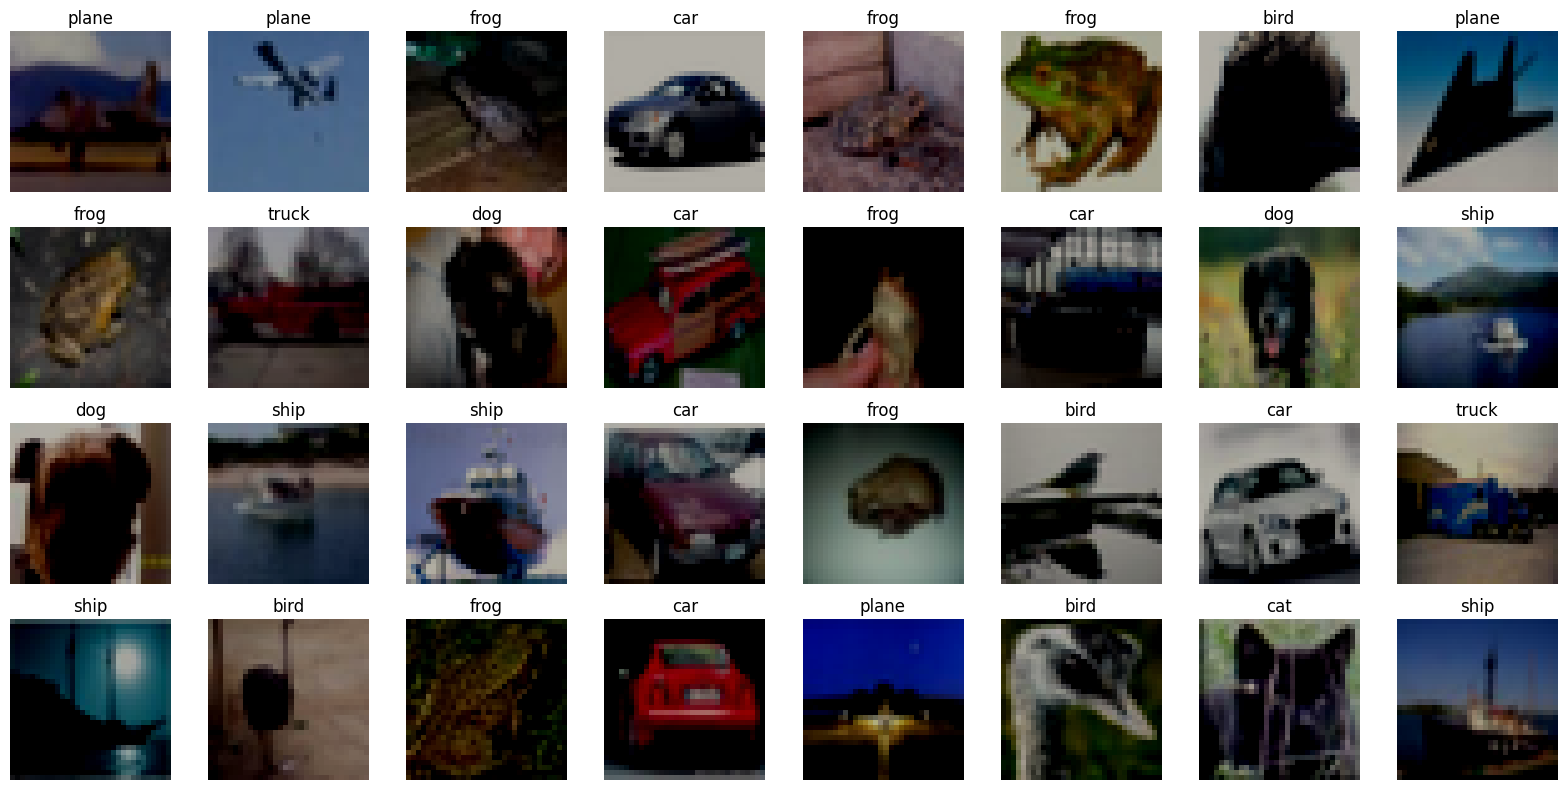

In [7]:
show_data(train_loader)

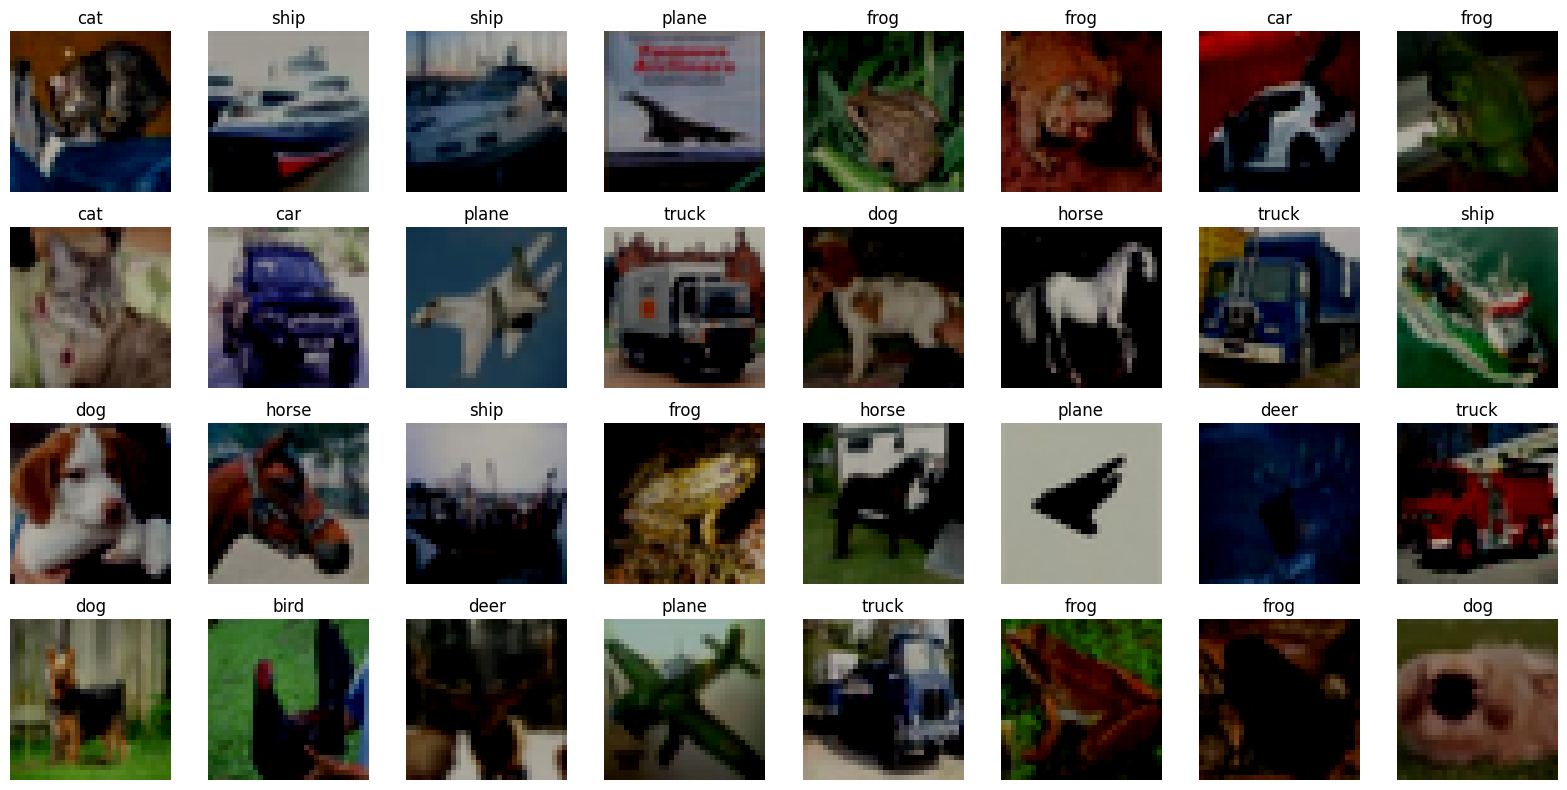

In [8]:
show_data(test_loader)

3. Реализация сверточной нейронной сети VGG-19

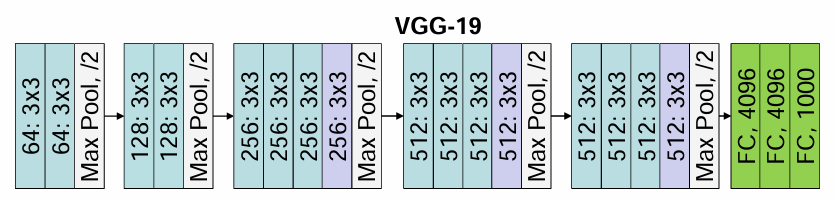

In [9]:
class VGG19(nn.Module):
    def __init__(self, classes):
        super(VGG19, self).__init__()
        self.features = self.add_layers([64, 64, 'm', 128, 128, 'm', 256, 256, 256, 256, 'm', 512, 512, 512, 512, 'm', 512, 512, 512, 512, 'm'])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, classes)
        )

    def add_layers(self, configuration_nn):
        layers = []
        сhannels = 3
        for x in configuration_nn:
            if x == 'm':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(сhannels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                сhannels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [10]:
model = VGG19(len(classes))
model.to(device)

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

4. Гиперпараметры

Функция потерь - CrossEntropy, оптимизатор - Adam

In [11]:
learning_rate = 0.001
num_epochs = 40
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

5. Обучение и вывод графика ошибок

In [12]:
def train(model, data, epoch_сount, loss_function, optimizer):
    train_loss_history = []

    for epoch in range(epoch_сount):
        epoch_start = time.time()
        epoch_loss = []
        epoch_accuracy = []
        for i, (images, labels) in enumerate(data):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            epoch_loss.append(loss)
            epoch_accuracy.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))
            loss.backward()
            optimizer.step()

        train_loss_history.append(torch.stack(epoch_loss).mean().cpu().detach().numpy())
        accuracy = torch.stack(epoch_accuracy).mean().item()
        loss = torch.stack(epoch_loss).mean().item()
        elapsed_time = time.time() - epoch_start
        print(f"Эпоха: {epoch + 1}/{num_epochs}, точность = {accuracy:.4f}, потери = {loss:.4f}, время = {elapsed_time:.4f} секунд")
    plt.plot(range(1, num_epochs + 1), train_loss_history, color='pink', marker='o')
    plt.xlabel("Эпохи")
    plt.ylabel("Потери")
    plt.grid(True)
    plt.show()

Эпоха: 1/40, точность = 0.1963, потери = 2.0085, время = 39.3168 секунд
Эпоха: 2/40, точность = 0.3090, потери = 1.7302, время = 39.9696 секунд
Эпоха: 3/40, точность = 0.3727, потери = 1.5679, время = 39.2175 секунд
Эпоха: 4/40, точность = 0.4675, потери = 1.3832, время = 39.5772 секунд
Эпоха: 5/40, точность = 0.5878, потери = 1.1598, время = 39.4701 секунд
Эпоха: 6/40, точность = 0.6568, потери = 0.9822, время = 39.5553 секунд
Эпоха: 7/40, точность = 0.7066, потери = 0.8650, время = 39.2988 секунд
Эпоха: 8/40, точность = 0.7433, потери = 0.7731, время = 39.4544 секунд
Эпоха: 9/40, точность = 0.7622, потери = 0.7195, время = 39.4338 секунд
Эпоха: 10/40, точность = 0.7967, потери = 0.6278, время = 39.4782 секунд
Эпоха: 11/40, точность = 0.8116, потери = 0.5871, время = 39.4058 секунд
Эпоха: 12/40, точность = 0.8360, потери = 0.5178, время = 39.4958 секунд
Эпоха: 13/40, точность = 0.8450, потери = 0.4868, время = 39.4076 секунд
Эпоха: 14/40, точность = 0.8538, потери = 0.4622, время = 39

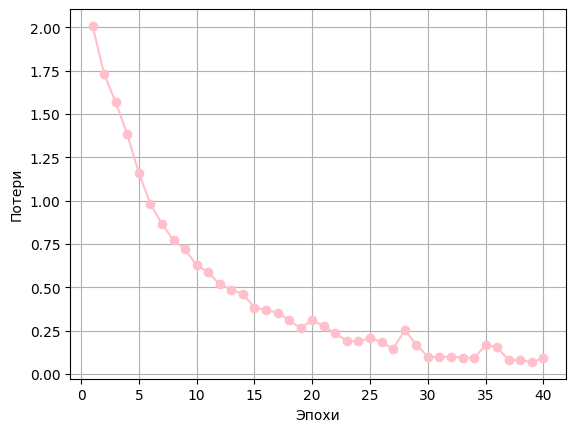

In [13]:
train(model, train_loader, num_epochs, loss_function, optimizer)

6. Тестирование

In [14]:
def test(data_loader, model, device):
    total_correct = 0
    total_loss = 0.0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total_correct += (predicted == labels).sum().item()
            total_loss += loss_function(outputs, labels)
            total += labels.size(0)
    return total_correct / total, total_loss / total

In [15]:
test_accuracy, test_loss = test(test_loader, model, device)
print(f"Точность на тестовом наборе: {test_accuracy}")
print(f"Потери на тестовом наборе: {test_loss}")

Точность на тестовом наборе: 0.8579
Потери на тестовом наборе: 0.011434406973421574
